<a href="https://colab.research.google.com/github/Astro-Beam/ASTRO/blob/main/Neural%20Networks/Denoising_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Necessary dependencies / libraries

In [1]:
#Run this block to import the necessary dependencies
!pip install torch torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from scipy.optimize import curve_fit
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler

#Create the spectral line with the added gaussian noise

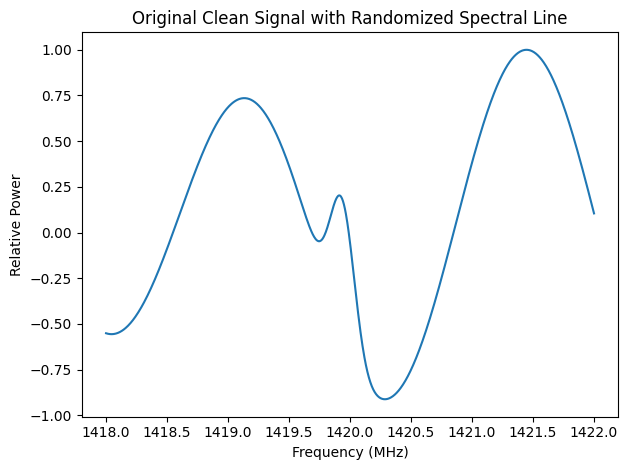

In [5]:
# Function to generate a clean spectral line signal (without noise)
def generate_clean_signal(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)

    # Add randomness to the background signal generation
    random_factor1 = np.random.uniform(0.05, 0.5)
    random_factor2 = np.random.uniform(0.05, 0.5)
    background_signal = (np.sin(2 * np.pi * random_factor1 * freq_range) + random_factor2 * np.sin(2 * np.pi * random_factor2 * freq_range))

    # Randomize the spectral line position between 1419.9 and 1420.1 MHz
    spectral_line_center = np.random.uniform(1419.9, 1420.1)

    # Add the spectral line at the random frequency
    spectral_line_shape = np.exp(-0.5 * ((freq_range - spectral_line_center) / 0.1)**2)
    clean_signal = background_signal + spectral_line_shape

    # Normalize the signal to be between -1 and 1
    clean_signal = clean_signal / np.max(np.abs(clean_signal))

    return clean_signal

# Generate the clean signal
n_samples = 1000
freq_range = np.linspace(1418, 1422, n_samples)
clean_signal = generate_clean_signal(n_samples)

# Plot the clean signal
plt.plot(freq_range, clean_signal)
plt.title("Original Clean Signal with Randomized Spectral Line")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Relative Power")

# Show the plots
plt.tight_layout()
plt.show()

#Create the training dataset

##Comments

Explaining the comments and the choices made in the code:
- `# Convert to PyTorch tensors` - A torch.tensor is a multi-dimensional matrix containing elements of a single data type. We convert the data into a PyTorch tensor in order to feed this data into PyTorch models, such as our autoencoder, and use it for forward passes, training, and evaluation.
- `torch.float32` - It means that each element in the tensor will be stored as a 32-bit floating point number (a common data type for numeric operations in neural networks).
It ensures that the data is in a format suitable for floating-point computations, which is critical for training neural networks in PyTorch since most deep learning operations work with floating point numbers.
- `# Batch size` - Batch size is a hyperparameter that defines the number of samples for the autoencoder to work through before updating internal model parameters

##Code

In [6]:
# Signal parameters
n_samples = 1000  # Number of sample measurements
freq_range = np.linspace(1418, 1422, n_samples)  # Frequencies of the signal (with a bandwidth of 4 MHz)

# We define a function to generate a clean spectral line signal (without noise)
def generate_clean_signal(n_samples):
    freq_range = np.linspace(1418, 1422, n_samples)

    # Add randomness to the background signal generation
    random_factor1 = np.random.uniform(0.05, 0.5)
    random_factor2 = np.random.uniform(0.05, 0.5)
    background_signal = (np.sin(2 * np.pi * random_factor1 * freq_range) + random_factor2 * np.sin(2 * np.pi * random_factor2 * freq_range))

    # Randomize the spectral line position between 1419.9 and 1420.1 MHz
    spectral_line_center = np.random.uniform(1419.9, 1420.1)

    # Add the spectral line at the random frequency
    spectral_line_shape = np.exp(-0.5 * ((freq_range - spectral_line_center) / 0.1)**2)
    clean_signal = background_signal + spectral_line_shape

    # Normalize the signal to be between -1 and 1
    clean_signal = clean_signal / np.max(np.abs(clean_signal))

    return clean_signal

# Generate a dataset of signals with spectral lines
n_signals = 3000  # Number of signals to generate
signals = np.array([generate_clean_signal(n_samples) for _ in range(n_signals)])

# Convert to PyTorch tensors
signals_tensor = torch.tensor(signals, dtype=torch.float32)

# Create a DataLoader for batching
batch_size = 64 # Batch size
dataset = TensorDataset(signals_tensor)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

#Define the autoencoder

##Comments

Comments:
- `nn.Module` is the base class for all neural networks in PyTorch.
- `ReLU (nn.ReLU())` - This is a popular activation function that introduces non-linearity into the model (Activation functions are essential in neural networks as they determine the output of a node given an input or set of inputs). It helps to handle complex data distributions and makes the model more powerful. The **Rectified Linear Unit** (ReLU) is one of the most widely used activation functions in deep learning. The ReLU function is defined as: **ReLU(x) = max(0, x)**. This means that if the input x is positive, the output will be x. If the input x is negative, the output will be 0.
- `nn.Linear(n_samples, 512)` - The first layer takes in the input (which has n_samples data points) and reduces it to 512 neurons.
- `nn.Linear(512, 128)` - This second layer further compresses the 512 neurons down to 128 neurons.
- `nn.Linear(128, 32)` - The final layer compresses the 128 neurons down to 32 neurons, which is the **latent space representation**. This is where the most significant compression occurs.
- `nn.Tanh()` - We use the **tanh** activation function, so that our values are between -1 and 1.

- `nn.Sigmoid()` - [DEPRECATED] The **sigmoid activation function** outputs values between 0 and 1. It introduces non-linearity and is particularly useful for making sure the output remains within a specific range.

##Code

In [7]:
class DenoisingAutoencoder(nn.Module):
    def __init__(self):
        super(DenoisingAutoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(n_samples, 512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU()
        )
        # Decoder with Tanh for negative values
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 512),
            nn.ReLU(),
            nn.Linear(512, n_samples),
            nn.Tanh()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Initialize the DAE model
dae = DenoisingAutoencoder()

# Print the model architecture
print(dae)

DenoisingAutoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=1000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=1000, bias=True)
    (5): Tanh()
  )
)


#Define the training loop

##Comments

We then have to define the **loss function** and the **optimizer** we will use in our autoencoder, in order to create the training loop.
 - For the **loss function** we use the **Mean Squared Error** function, a popular loss function used in regression tasks that measures the average squared differences between predicted and actual values.
 - For the **optimizer** we use the **ADAM optimizer**. Adaptive Moment Estimation is an algorithm for optimization technique for gradient descent. The method is really efficient when working with large problem involving a lot of data or parameters. It requires less memory and is efficient. Intuitively, it is a combination of the ‘gradient descent with momentum’ algorithm and the ‘RMSP’ algorithm.

We have to consider the **number of epochs** for the best training of the autoencoder. Generally speaking, the number of epochs will change if the dataset is bigger.
 - The number of epochs should not be decided a-priori. We should run the training and monitor the training and validation losses over time and stop training when the validation loss reaches a plateau or starts increasing. This technique is called "**early stopping**" and is a good practice in machine learning.


##Code

Epoch [1/50], Loss: 0.0297
Epoch [2/50], Loss: 0.0097
Epoch [3/50], Loss: 0.0082
Epoch [4/50], Loss: 0.0072
Epoch [5/50], Loss: 0.0066
Epoch [6/50], Loss: 0.0046
Epoch [7/50], Loss: 0.0035
Epoch [8/50], Loss: 0.0031
Epoch [9/50], Loss: 0.0023
Epoch [10/50], Loss: 0.0022
Epoch [11/50], Loss: 0.0021
Epoch [12/50], Loss: 0.0021
Epoch [13/50], Loss: 0.0022
Epoch [14/50], Loss: 0.0018
Epoch [15/50], Loss: 0.0019
Epoch [16/50], Loss: 0.0017
Epoch [17/50], Loss: 0.0015
Epoch [18/50], Loss: 0.0016
Epoch [19/50], Loss: 0.0014
Epoch [20/50], Loss: 0.0012
Epoch [21/50], Loss: 0.0012
Epoch [22/50], Loss: 0.0015
Epoch [23/50], Loss: 0.0016
Epoch [24/50], Loss: 0.0016
Epoch [25/50], Loss: 0.0015
Epoch [26/50], Loss: 0.0012
Epoch [27/50], Loss: 0.0011
Epoch [28/50], Loss: 0.0011
Epoch [29/50], Loss: 0.0010
Epoch [30/50], Loss: 0.0010
Epoch [31/50], Loss: 0.0015
Epoch [32/50], Loss: 0.0012
Epoch [33/50], Loss: 0.0011
Epoch [34/50], Loss: 0.0009
Epoch [35/50], Loss: 0.0011
Epoch [36/50], Loss: 0.0011
E

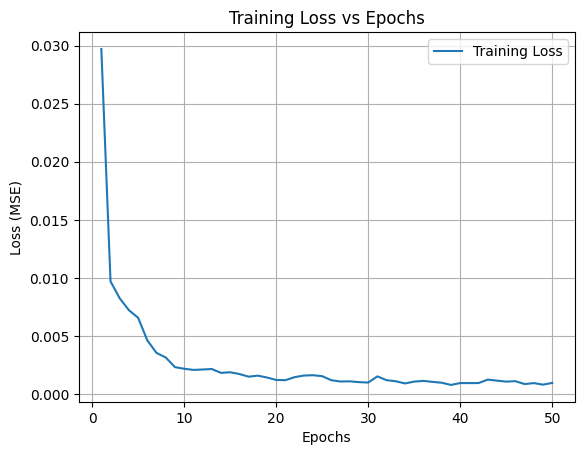

In [8]:
# Loss function (Mean Squared Error) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(dae.parameters(), lr=0.001)

# Noise generation for corrupting the input
def add_noise(signal, noise_level=0.1):
    noise = torch.normal(0, noise_level, signal.shape)
    noisy_signal = signal + noise
    return noisy_signal

# Number of epochs
n_epochs = 50

# List to store the loss values for each epoch
loss_values = []

for epoch in range(n_epochs):
    for data in dataloader:
        clean_signals = data[0]  # Get the clean signals batch

        # Corrupt the clean signals with noise
        noisy_signals = add_noise(clean_signals)

        # Forward pass: autoencoder's prediction from noisy signals
        reconstructed_signals = dae(noisy_signals)

        # Compute the loss (reconstruction error) between the original clean signal and the reconstructed signal
        loss = criterion(reconstructed_signals, clean_signals)

        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Store the loss for each epoch
    loss_values.append(loss.item())

    # Print loss at the end of each epoch
    print(f'Epoch [{epoch+1}/{n_epochs}], Loss: {loss.item():.4f}')


# Plot the loss versus epochs
plt.plot(range(1, n_epochs + 1), loss_values, label='Training Loss')
plt.title('Training Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.grid(True)
plt.legend()
plt.show()

#Autoencoder testing and results visualization

<ipython-input-14-722c0a5c427d>:40: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_right = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
<ipython-input-14-722c0a5c427d>:49: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


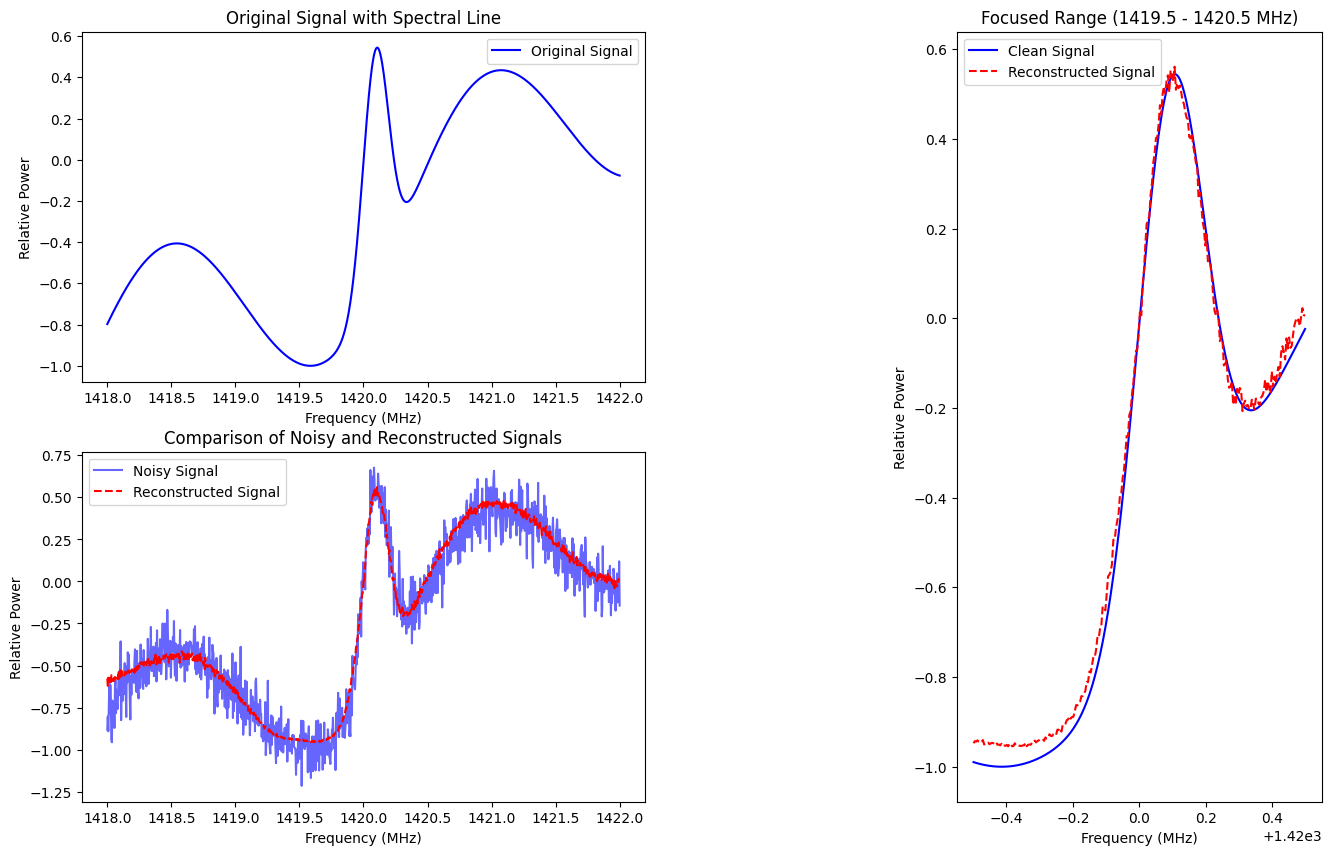

In [14]:
# Function to add noise to the signal
def add_noise(signal, noise_level=0.1):
    noise = np.random.normal(0, noise_level, len(signal))
    return signal + noise

# Test the autoencoder with a sample signal
sample_signal = generate_clean_signal(n_samples)
sample_signal_noised = add_noise(sample_signal)  # Add noise to the sample signal
sample_signal_tensor = torch.tensor(sample_signal_noised, dtype=torch.float32).unsqueeze(0)  # Add batch dimension

# Pass the signal through the autoencoder
with torch.no_grad():
    reconstructed_signal = dae(sample_signal_tensor).squeeze(0).numpy()

# Define the focus range
focus_range_mask = (freq_range >= 1419.5) & (freq_range <= 1420.5)
focused_freq_range = freq_range[focus_range_mask]
focused_clean_signal = sample_signal[focus_range_mask]
focused_reconstructed_signal = reconstructed_signal[focus_range_mask]

# Create the subplots in a 2x2 grid
fig, axs = plt.subplots(2, 2, figsize=(16, 10))

# Upper left plot: Original Signal with Spectral Line
axs[0, 0].plot(freq_range, sample_signal, label='Original Signal', color='blue')
axs[0, 0].set_title('Original Signal with Spectral Line')
axs[0, 0].set_xlabel('Frequency (MHz)')
axs[0, 0].set_ylabel('Relative Power')
axs[0, 0].legend()

# Down left plot: Comparison of Clean, Noisy, and Reconstructed Signal
axs[1, 0].plot(freq_range, sample_signal_noised, label='Noisy Signal', color='blue', alpha=0.6)  # Plot the noised signal
axs[1, 0].plot(freq_range, reconstructed_signal, label='Reconstructed Signal', color='red', linestyle='dashed')
axs[1, 0].set_title('Comparison of Noisy and Reconstructed Signals')
axs[1, 0].set_xlabel('Frequency (MHz)')
axs[1, 0].set_ylabel('Relative Power')
axs[1, 0].legend()

# Right-side plot: Focused Clean vs Reconstructed Signal (Zoomed in 1419.5 - 1420.5 MHz for better visualization)
ax_right = plt.subplot2grid((2, 3), (0, 2), rowspan=2)
ax_right.plot(focused_freq_range, focused_clean_signal, label='Clean Signal', color='blue')
ax_right.plot(focused_freq_range, focused_reconstructed_signal, label='Reconstructed Signal', color='red', linestyle='dashed')
ax_right.set_title('Focused Range (1419.5 - 1420.5 MHz)')
ax_right.set_xlabel('Frequency (MHz)')
ax_right.set_ylabel('Relative Power')
ax_right.legend()

# Show the plots
plt.tight_layout()
plt.show()